In [ ]:

import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt



def parse_first_n(path, n=10000000):
    g = gzip.open( path, 'r')
    for i, l in enumerate(g):
        if i >= n:
            break
        yield json.loads(l)


california_reviews = pd.DataFrame(parse_first_n("data/review-California.json.gz"))
california_metadata = pd.DataFrame(parse_first_n("data/meta-California (1).json.gz"))

In [381]:
california_reviews

,user_id,name,time,rating,text,pics,resp,gmap_id
0,113165551130476225599,Michael Rizal,1599164133778,5.0,Great company. Amazing customer service and th...,None,None,0x80c2c98c0e3c16fd:0x29ec8a728764fdf9
1,101226371370637614545,Faranak Rafizadeh,1618261672851,5.0,Nice people\nhelpful,None,None,0x80c2c98c0e3c16fd:0x29ec8a728764fdf9
2,111167703666981482712,Javier Perez,1524515066787,5.0,None,None,None,0x80c2c98c0e3c16fd:0x29ec8a728764fdf9
3,116230882057344020235,Luis P.,1499739139293,5.0,None,None,None,0x80c2c98c0e3c16fd:0x29ec8a728764fdf9
4,104181659835585235223,His Mama Cakez,1621410940638,3.0,None,None,None,0x80c2c98c0e3c16fd:0x29ec8a728764fdf9
...,...,...,...,...,...,...,...,...
999995,109700572377575760278,Juan Rodriguez,1569124811165,5.0,None,None,None,0x80dce864ab86965f:0xd3dc4aec2d2f720c
999996,105608363717492612316,David Lang,1560819594604,5.0,None,None,None,0x80dce864ab86965f:0xd3dc4aec2d2f720c
999997,115074808978970419413,Armando Diaz,1627329976603,5.0,None,None,None,0x80dce864ab86965f:0xd3dc4aec2d2f720c
999998,107487112776647972147,Theresa Olah,1554409414620,5.0,None,None,None,0x80dcdf60586bc8ed:0xca9b1cea7549b0a


## **1. How the branding of a business affects reviews?**

In [202]:
####################################################
# Finding a good threshold that consider a brand
####################################################

location_counts = california_metadata.groupby('name')['gmap_id'].nunique()
total_count = california_metadata.get('gmap_id').nunique()

#Calculate proportion for each business
location_proportion = location_counts/total_count

print('Maximum Proportion is:',location_proportion.max())


Maximum Proportion is: 0.005717804705983233


In [336]:
# Create a df that has proportion for each company and filter out brand vs non-brand 
brand_proportion_df = pd.DataFrame()
brand_proportion_df = brand_proportion_df.assign(Proportion = proportion_location_counts)

brand_threshold = 0.0005

brand_proportion_df['is_brand'] = (
    brand_proportion_df['Proportion'] >= brand_threshold
)
# See the count between non-brand vs brand 
brand_proportion_df['is_brand'].value_counts()


is_brand
False    385882
True         62
Name: count, dtype: int64

<Axes: xlabel='is_brand'>

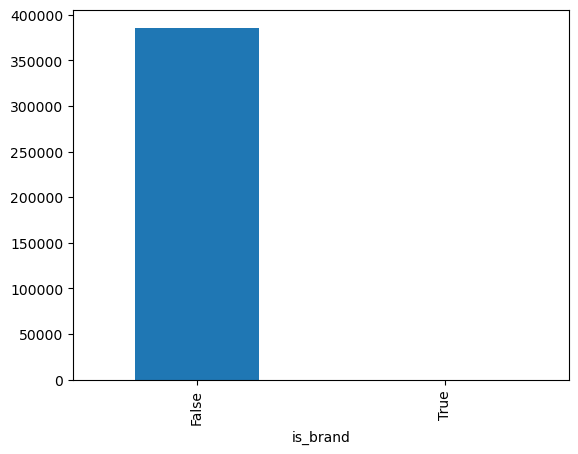

In [337]:
# Normal Bar Chart (imbalance)
brand_proportion_df['is_brand'].value_counts().plot(kind='bar')


<Axes: xlabel='is_brand'>

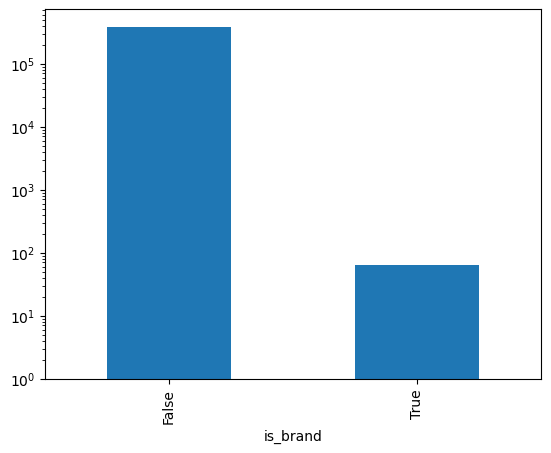

In [338]:
# Log scale - balance out 
# False is around 10⁵ (hundreds of thousands)
# True is around 10³ (a few thousand)
brand_proportion_df['is_brand'].value_counts().plot(kind='bar', log=True)


In [339]:
# Create statistics to compare average rating between brand vs non-brand
california_metadata['brand_proportion'] = (
    california_metadata['name'].map(location_proportion)
)
california_metadata['is_brand'] = (
    california_metadata['brand_proportion'] >= brand_threshold
)
california_metadata.groupby('is_brand')['avg_rating'].agg(['mean','median','std'])
 

,mean,median,std
is_brand,,,
False,4.312524,4.4,0.617623
True,3.834740,3.9,0.582934


##### Conclusion: On average, independent businesses are rated higher than branded chains.

## **2. In which business categories do independent businesses receive higher customer ratings than branded chains?**

In [340]:
# # Change first item in the list => a string of category
california_metadata['category_main'] = california_metadata['category'].str[0]  
california_metadata

print('Highest number of review:',california_metadata.get('num_of_reviews').max())

print('Total number of category:',california_metadata.groupby('category_main').count().shape[0])

# Setting review number to indetify successful businesses
review_num_threshold = 1000
success_business = california_metadata[california_metadata.get('num_of_reviews') > review_num_threshold]
success_business

#Compare rating between non-brand and brand in different category
category_brand_ratings = (
    success_business
        .groupby(['category_main', 'is_brand'])['avg_rating']
        .median()
        .unstack()
)

# Keep only category that has both 
comparable_categories = category_brand_ratings.dropna()
comparable_categories

Highest number of review: 9998
Total number of category: 3579


is_brand,False,True
category_main,,
Auto parts store,4.20,4.2
Car rental agency,3.80,4.3
Cell phone store,4.80,4.8
Chicken restaurant,4.00,3.8
Chinese restaurant,4.20,4.1
Clothing store,4.20,4.1
Coffee shop,4.60,4.1
Department store,4.10,4.2
Diner,4.40,4.0


In [341]:
#Measure who performs better
comparable_categories["compare"] = comparable_categories[False] - comparable_categories[True]

#Identify categories where independents outperform
independent_win = comparable_categories[comparable_categories.get('compare') >0].sort_values(by="compare", ascending=False)
independent_win

/var/folders/tl/nq7m6l0d7g3_80l5ngq1x0t00000gn/T/ipykernel_68614/674448337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparable_categories["compare"] = comparable_categories[False] - comparable_categories[True]


is_brand,False,True,compare
category_main,,,
Pizza restaurant,4.50,3.7,0.80
Fast food restaurant,4.40,3.7,0.70
Restaurant,4.20,3.6,0.60
Coffee shop,4.60,4.1,0.50
Diner,4.40,4.0,0.40
Chicken restaurant,4.00,3.8,0.20
Mexican restaurant,4.30,4.1,0.20
Truck stop,4.15,4.0,0.15
Chinese restaurant,4.20,4.1,0.10


##### Top categorical which independent outperform brand

## **3. Which categories are saturated with independents but still highly rated?**
##### *“Saturated” means many independent businesses competing in the same category => has a large number of independent businesses*

In [ ]:
independent = california_metadata[california_metadata.get('is_brand') == False]
independent

# Identify saturated category 
saturated = independent.groupby('category_main')['name'].count().reset_index(name='count_saturated').sort_values(by='count_saturated', ascending=False).reset_index(drop=True)

print("Highest number of saturated:",saturated.get('count_saturated').iloc[0])

# attach count to each row
independent['count_saturated'] = independent['category_main'].map(
    saturated.set_index('category_main')['count_saturated']
)

# flag saturated
saturated_threshold = 5000
independent['is_saturated'] = independent['count_saturated'] > saturated_threshold

independent

Highest number of saturated: 11906


/var/folders/tl/nq7m6l0d7g3_80l5ngq1x0t00000gn/T/ipykernel_68614/4110933618.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  independent['count_saturated'] = independent['category_main'].map(
/var/folders/tl/nq7m6l0d7g3_80l5ngq1x0t00000gn/T/ipykernel_68614/4110933618.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  independent['is_saturated'] = independent['count_saturated'] > saturated_threshold


,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,category_main,brand_proportion,is_brand,count_saturated,is_saturated
0,City Textile,"City Textile, 3001 E Pico Blvd, Los Angeles, C...",0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,None,34.018891,-118.215290,[Textile exporter],4.5,6,None,None,None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,Textile exporter,0.000002,False,2.0,False
1,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",0x80c2c778e3b73d33:0xbdc58662a4a97d49,None,34.058092,-118.292130,[Korean restaurant],4.4,18,None,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...","{'Service options': ['Takeout', 'Dine-in', 'De...",Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,Korean restaurant,0.000002,False,757.0,False
2,Nova Fabrics,"Nova Fabrics, 2200 E 11th St, Los Angeles, CA ...",0x80c2c89923b27a41:0x32041559418d447,None,34.023669,-118.232930,[Fabric store],3.3,6,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...","{'Service options': ['In-store shopping'], 'Pa...",Open ⋅ Closes 5PM,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,Fabric store,0.000002,False,315.0,False
3,Nobel Textile Co,"Nobel Textile Co, 719 E 9th St, Los Angeles, C...",0x80c2c632f933b073:0xc31785961fe826a6,None,34.036694,-118.249421,[Fabric store],4.3,7,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",{'Service options': ['In-store pickup']},Open ⋅ Closes 5PM,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,Fabric store,0.000002,False,315.0,False
4,Matrix International Textiles,"Matrix International Textiles, 1363 S Bonnie B...",0x80c2cf163db6bc89:0x219484e2edbcfa41,None,34.015505,-118.181839,[Fabric store],3.5,6,None,"[[Thursday, 8:30AM–5:30PM], [Friday, 8:30AM–5:...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 5:30PM,"[0x80c2cf042a5d9561:0xd0024ad6f81f1335, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,Fabric store,0.000002,False,315.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515955,Taco Surf,"Taco Surf, 16281 Pacific Coast Hwy, Surfside, ...",0x80dd256e5bb86d89:0x12ec8ff3f2aedfa7,"Cantina outpost offering tacos, burritos & oth...",33.724634,-118.078770,[Mexican restaurant],4.5,821,$$,"[[Wednesday, 11AM–10PM], [Thursday, 11AM–10PM]...","{'Service options': ['Curbside pickup', 'Takeo...",NaN,"[0x80dd25a7c4575761:0xd35a60dc60000649, 0x80dd...",https://www.google.com/maps/place//data=!4m2!3...,Mexican restaurant,0.000010,False,10253.0,True
515957,California Citrus State Historic Park,"California Citrus State Historic Park, 9400 Du...",0x80dcba7983a059af:0x2a006c069483d3d2,Park dedicated to preserving the history of Ca...,33.898611,-117.425703,"[Park, Tourist attraction]",4.7,763,None,"[[Wednesday, 8AM–5PM], [Thursday, 8AM–5PM], [F...",{'Accessibility': ['Wheelchair accessible entr...,NaN,"[0x80dcb21eefbd19f5:0x8ebb31f8a91dc2d3, 0x80dc...",https://www.google.com/maps/place//data=!4m2!3...,Park,0.000002,False,9005.0,True
515958,California Citrus,"California Citrus, 1999 Van Buren Boulevard, R...",0x80dcb09e3af6228b:0xa55fc2f742364e02,None,33.898299,-117.428067,[State park],4.8,96,None,None,{'Accessibility': ['Wheelchair accessible entr...,NaN,"[0x80dcb09dfb76baef:0x5156f914ebbbe, 0x80dcb1e...",https://www.google.com/maps/place//data=!4m2!3...,State park,0.000002,False,270.0,False
515959,Recreation Park Playground,"Recreation Park Playground, 701-939 Federation...",0x80dd31c81d5f153d:0x501886193d0102e7,None,33.775862,-118.135669,[Playground],4.3,17,None,None,{'Accessibility': ['Wheelchair accessible entr...,NaN,"[0x80dd31044c86de89:0xea5a9038c8f9e2eb, 0x80dd...",https://www.google.com/maps/place//data=!4m2!3...,Playground,0.000002

### **3-case framework**
#### **a. Saturated and poorly rated → Bad market**


In [380]:
# Compute median rating per category (Series)
median_rating_by_category = (
    independent.groupby('category_main')['avg_rating']
    .median()
)
median_rating_by_category

#how to filter actual businesses ex: park,..

category_main
3D printing service                   5.0
ATM                                   4.0
ATV dealer                            4.4
ATV rental service                    4.6
ATV repair shop                       4.5
                                     ... 
Youth group                           5.0
Youth hostel                          3.0
Youth organization                    4.4
Youth social services organization    4.4
Zoo                                   4.6
Name: avg_rating, Length: 3579, dtype: float64

In [372]:
# Map back to independent 
independent['median_rating'] = (
    independent['category_main'].map(median_rating_by_category)
)
independent

/var/folders/tl/nq7m6l0d7g3_80l5ngq1x0t00000gn/T/ipykernel_68614/1229740027.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  independent['median_rating'] = (


,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,...,MISC,state,relative_results,url,category_main,brand_proportion,is_brand,count_saturated,is_saturated,median_rating
0,City Textile,"City Textile, 3001 E Pico Blvd, Los Angeles, C...",0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,None,34.018891,-118.215290,[Textile exporter],4.5,6,None,...,None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,Textile exporter,0.000002,False,2.0,False,4.5
1,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",0x80c2c778e3b73d33:0xbdc58662a4a97d49,None,34.058092,-118.292130,[Korean restaurant],4.4,18,None,...,"{'Service options': ['Takeout', 'Dine-in', 'De...",Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,Korean restaurant,0.000002,False,757.0,False,4.3
2,Nova Fabrics,"Nova Fabrics, 2200 E 11th St, Los Angeles, CA ...",0x80c2c89923b27a41:0x32041559418d447,None,34.023669,-118.232930,[Fabric store],3.3,6,None,...,"{'Service options': ['In-store shopping'], 'Pa...",Open ⋅ Closes 5PM,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,Fabric store,0.000002,False,315.0,False,4.3
3,Nobel Textile Co,"Nobel Textile Co, 719 E 9th St, Los Angeles, C...",0x80c2c632f933b073:0xc31785961fe826a6,None,34.036694,-118.249421,[Fabric store],4.3,7,None,...,{'Service options': ['In-store pickup']},Open ⋅ Closes 5PM,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,Fabric store,0.000002,False,315.0,False,4.3
4,Matrix International Textiles,"Matrix International Textiles, 1363 S Bonnie B...",0x80c2cf163db6bc89:0x219484e2edbcfa41,None,34.015505,-118.181839,[Fabric store],3.5,6,None,...,{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 5:30PM,"[0x80c2cf042a5d9561:0xd0024ad6f81f1335, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,Fabric store,0.000002,False,315.0,False,4.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515955,Taco Surf,"Taco Surf, 16281 Pacific Coast Hwy, Surfside, ...",0x80dd256e5bb86d89:0x12ec8ff3f2aedfa7,"Cantina outpost offering tacos, burritos & oth...",33.724634,-118.078770,[Mexican restaurant],4.5,821,$$,...,"{'Service options': ['Curbside pickup', 'Takeo...",NaN,"[0x80dd25a7c4575761:0xd35a60dc60000649, 0x80dd...",https://www.google.com/maps/place//data=!4m2!3...,Mexican restaurant,0.000010,False,10253.0,True,4.3
515957,California Citrus State Historic Park,"California Citrus State Historic Park, 9400 Du...",0x80dcba7983a059af:0x2a006c069483d3d2,Park dedicated to preserving the history of Ca...,33.898611,-117.425703,"[Park, Tourist attraction]",4.7,763,None,...,{'Accessibility': ['Wheelchair accessible entr...,NaN,"[0x80dcb21eefbd19f5:0x8ebb31f8a91dc2d3, 0x80dc...",https://www.google.com/maps/place//data=!4m2!3...,Park,0.000002,False,9005.0,True,4.5
515958,California Citrus,"California Citrus, 1999 Van Buren Boulevard, R...",0x80dcb09e3af6228b:0xa55fc2f742364e02,None,33.898299,-117.428067,[State park],4.8,96,None,...,{'Accessibility': ['Wheelchair accessible entr...,NaN,"[0x80dcb09dfb76baef:0x5156f914ebbbe, 0x80dcb1e...",https://www.google.com/maps/place//data=!4m2!3...,State park,0.000002,False,270.0,False,4.7
515959,Recreation Park Playground,"Recreation Park Playground, 701-939 Federation...",0x80dd31c81d5f153d:0x501886193d0102e7,None,33.775862,-118.135669,[Playground],4.3,17,None,...,{'Accessibility': ['Wheelchair accessible entr...,NaN,"[0x80dd31044c86de89:0xea5a9038c8f9e2eb, 0x80dd...",https://www.google.com/maps/place//data=!4m2!3...,Playground,0.000002,False,384.0,False,4.5


In [374]:
independent.get('avg_rating').median()
independent_rating_threshold = 4.4

bad_market = independent[(independent.get('is_saturated') == True) & (independent.get('median_rating') < 4.4)]
bad_market.groupby('category_main').count()

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,brand_proportion,is_brand,count_saturated,is_saturated,median_rating
category_main,,,,,,,,,,,,,,,,,,,,
Grocery store,6620,6615,6620,2077,6620,6620,6620,6620,6620,1776,6368,6381,4897,6283,6620,6620,6620,6620,6620,6620
Mexican restaurant,10253,10241,10253,3321,10253,10253,10253,10253,10253,7009,9859,10219,7726,9632,10253,10253,10253,10253,10253,10253
Nail salon,5669,5660,5669,16,5669,5669,5669,5669,5669,16,5302,5116,5122,5521,5669,5669,5669,5669,5669,5669


In [359]:
independent['is_saturated'].value_counts()


is_saturated
False    419546
True      59492
Name: count, dtype: int64

#### **b. Saturated and highly rated → Competitive but viable**

In [375]:
competitive_market = independent[(independent.get('is_saturated') == True) & (independent.get('median_rating') >= 4.4)]
competitive_market.groupby('category_main').count()

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,brand_proportion,is_brand,count_saturated,is_saturated,median_rating
category_main,,,,,,,,,,,,,,,,,,,,
Auto repair shop,8558,8540,8558,3,8558,8558,8558,8558,8558,42,7572,8158,7373,8293,8558,8558,8558,8558,8558,8558
Beauty salon,7481,7466,7481,53,7481,7481,7481,7481,7481,56,5989,6237,5867,7310,7481,7481,7481,7481,7481,7481
Park,9005,9005,9005,2279,9005,9005,9005,9005,9005,4,5449,8779,5099,8588,9005,9005,9005,9005,9005,9005
Restaurant,11906,11888,11906,3632,11906,11906,11906,11906,11906,5317,10734,11880,8933,9295,11906,11906,11906,11906,11906,11906


#### **c. Unsaturated and highly rated → Opportunity**

In [379]:
opportunity_market = independent[(independent.get('is_saturated') == False) & (independent.get('median_rating') >= 4.4) & (independent.get('num_of_reviews') > 500)]
opportunity_market.groupby('category_main').count().head(20)

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,brand_proportion,is_brand,count_saturated,is_saturated,median_rating
category_main,,,,,,,,,,,,,,,,,,,,
ATV rental service,2,2,2,0,2,2,2,2,2,0,2,0,2,2,2,2,2,2,2,2
Abundant Life church,1,1,1,0,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1
Acura dealer,9,9,9,0,9,9,9,9,9,0,9,9,6,9,9,9,9,9,9,9
Adult education school,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
Adventure sports center,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
Aerial sports center,1,1,1,0,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1
Aerospace company,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
Afghani restaurant,7,7,7,5,7,7,7,7,7,7,7,7,5,7,7,7,7,7,7,7
After school program,1,1,1,0,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1


## **4. How consistent are brands across regions within California?**


## **5. Do consumers rate businesses more harshly in high-expectation areas?**


## **6. Are negative reviews longer and more detailed than positive ones?**


## **7. Do service-related complaints dominate negative sentiment more than product-related ones?**

## **8. Which locations appear most favorable for opening a new independent business based on competition, customer sentiment, and ratings?**